# CosmoDC

### Goals
- How to interface QP and sacc
- How to create n(z) uncertainties from an ensemble of n(z)'s

### Requirements
- **A sacc file**: we will use the sacc file of Prat et al 2022 (2212.09345). This sacc file contains the summary statistics measured from the CosmoDC2 simulations using the DESC TXPipe pipeline. The summary statistics include the angular power spectra of the shear-shear, position-shear, and position-position correlations, as well as the cross-correlations between the different probes. The sacc file also contains the redshift distributions of the galaxies in the simulations. For more details see Prat et al 2022. The data can found in NERSC at '/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/gaussian/data_vectors'.

- **A series of QP ensenbles**: For this tutorials I have created a series of QP ensembles using the cosmoDC2_v1.1.4_image_with_photoz_v1 simulations. This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) by Sam Schmidt. We use all the available pixels and impose a 24.1 magnitude cut in the i-band following Prat et al. The edges of the tomographic bins are also taken from Prat et al.

### Special Dependencies
- **sacc**: standard DESC library to load and save data.
- **nz_prior**: this very own library, used to compute n(z) uncertainties from n(z) ensembles.
- **PACC** is a plotting library (https://github.com/jaimerzpP/pacc) for sacc files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qp
import sacc
import yaml
import scipy
import nz_prior as nzp

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18

### Load Data

In [ ]:
# Sacc file
dir1 = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2"
dir2 = "/home/jaimerzp/Documents/UCL/nz_prior/examples/data/image_nzs_bpz/"
s = sacc.Sacc.load_fits(f"{dir1}/summary_statistics_fourier_tjpcov.sacc")

source_0 = np.load(f"{dir2}lens_0.npz")
source_1 = np.load(f"{dir2}lens_1.npz")
source_2 = np.load(f"{dir2}lens_2.npz")
source_3 = np.load(f"{dir2}lens_3.npz")
source_4 = np.load(f"{dir2}lens_4.npz")
lens_0 = np.load(f"{dir2}lens_0.npz")
lens_1 = np.load(f"{dir2}lens_1.npz")
lens_2 = np.load(f"{dir2}lens_2.npz")
lens_3 = np.load(f"{dir2}lens_3.npz")
lens_4 = np.load(f"{dir2}lens_4.npz")

tomos = {'source_0': source_0,
        'source_1': source_1,
        'source_2': source_2,
        'source_3': source_3,
        'source_4': source_4,
        'lens_0': lens_0,
        'lens_1': lens_1,
        'lens_2': lens_2,
        'lens_3': lens_3,
        'lens_4': lens_4}

# Configuration
# This option controls how dense the prior covariance matrix will be.
# "None" means no cross-correlations between any of the parameters (diagonal covariance matrix).
# "BinWise" means cross-correlations only between parameters of the same tomographic bin (block-diagonal covariance matrix).
# "Full" means all parameters are correlated (full covariance matrix).
crosscorrs_method = "None" # "None", "BinWise" or "Full"

Assuming data rows are in the correct order as it was before version 1.0.


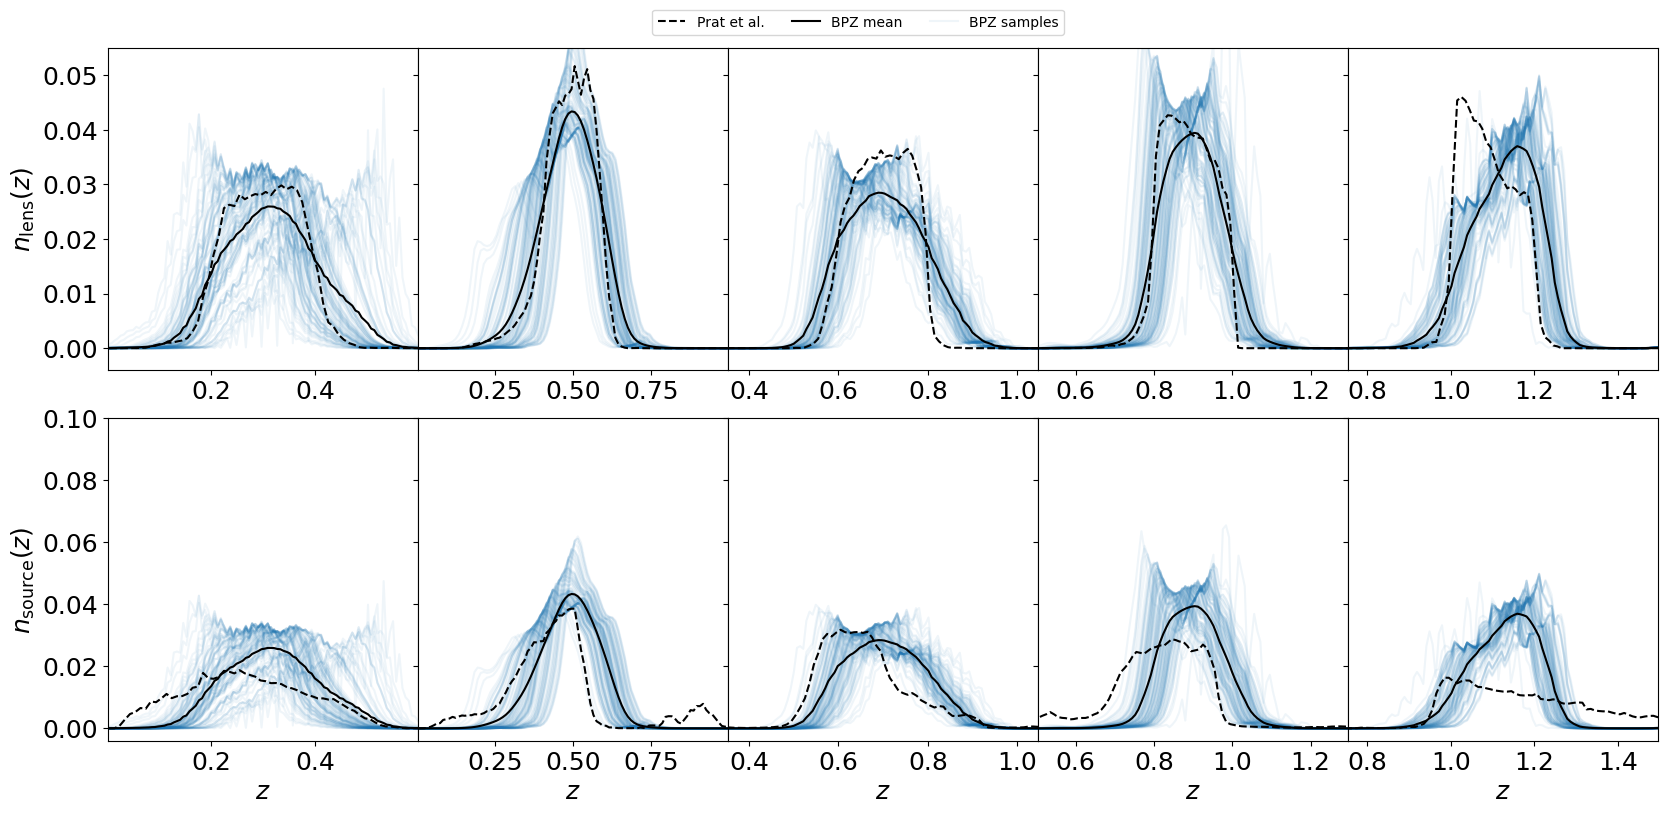

In [3]:
figure, axis = plt.subplots(2, 5, figsize=(5*4, 9))
figure.subplots_adjust(wspace=0, hspace=0.15)

#colors = ['limegreen', 'forestgreen', 'darkgreen', 'olive', 'orange']
lens_keys = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'] 
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    line3 = axis[0, i].plot(tomo['znodes'], tomo['photo_hists'][:, :100]/norm, '-', color='C0', alpha=0.07)
    line1, = axis[0, i].plot(spec.z, alpha*spec.nz, 'k--')
    line2, = axis[0, i].plot(tomo['znodes'], np.mean(tomo['photo_hists'], axis=1)/norm, 'k-')
    #axis[0].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    #axis[0, i].set_title(source_labels[i], y=0.8)
    axis[0, i].set_ylim([-0.004, 0.055])
    axis[0, i].set_xlim([tomo['znodes'][0], tomo['znodes'][-1]])
    if i == 0:
        axis[0, i].set_ylabel(r'$n_{\rm lens}(z)$')
    else:
        axis[0, i].set_yticklabels([])

#colors = ['skyblue', 'teal', 'blue', 'purple', 'darkviolet']
lens_keys = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))

    axis[1, i].plot(tomo['znodes'], tomo['photo_hists'][:, :100]/norm, '-', color='C0', alpha=0.07)
    axis[1, i].plot(spec.z, alpha*spec.nz, 'k--')
    axis[1, i].plot(tomo['znodes'], np.mean(tomo['photo_hists'], axis=1)/norm, 'k-')
    #axis[1].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    #axis[1, i].set_title(lens_labels[i], y=0.8)
    axis[1, i].set_ylim([-0.004, 0.1])
    axis[1, i].set_xlim([tomo['znodes'][0], tomo['znodes'][-1]])
    axis[1, i].set_xlabel(r'$z$')
    if i == 0:
        axis[1, i].set_ylabel(r'$n_{\rm source}(z)$')
    else:
        axis[1, i].set_yticklabels([])

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")
lines = [line1, line2, line3[0]]
labels = ["Prat et al.", "BPZ mean", "BPZ samples"]
figure.legend(lines, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.5, 0.93))
plt.show()

In [4]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tomo = tracers_dict[key]
        if len(tomo) == 2:
            nzs = tomo[1][:50].T
            zs = tomo[0]
        else:
            nzs = tomo['photo_hists'].T[:50].T
            zs = tomo['znodes']
        norms = np.sum(nzs, axis=0)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].plot(zs, nz_mean/np.sum(nz_mean), '-', color="k")
        axis[0,i].plot(zs, nzs/norms, '-', color='C0', alpha=0.1)
        cov = np.cov(nzs)
        err = np.sqrt(np.diag(cov))
        corr = cov/np.outer(err, err)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_ylim([-0.001, 0.1])
        axis[0,i].set_title(key)
        if i == 0:
            axis[0,i].set_ylabel(r'$n_{\rm lens}(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(corr, aspect='auto',
                            origin='lower', cmap='coolwarm',
                            vmin=-1, vmax=1,
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')
        if i > 0:
            axis[1,i].set_yticklabels([])

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

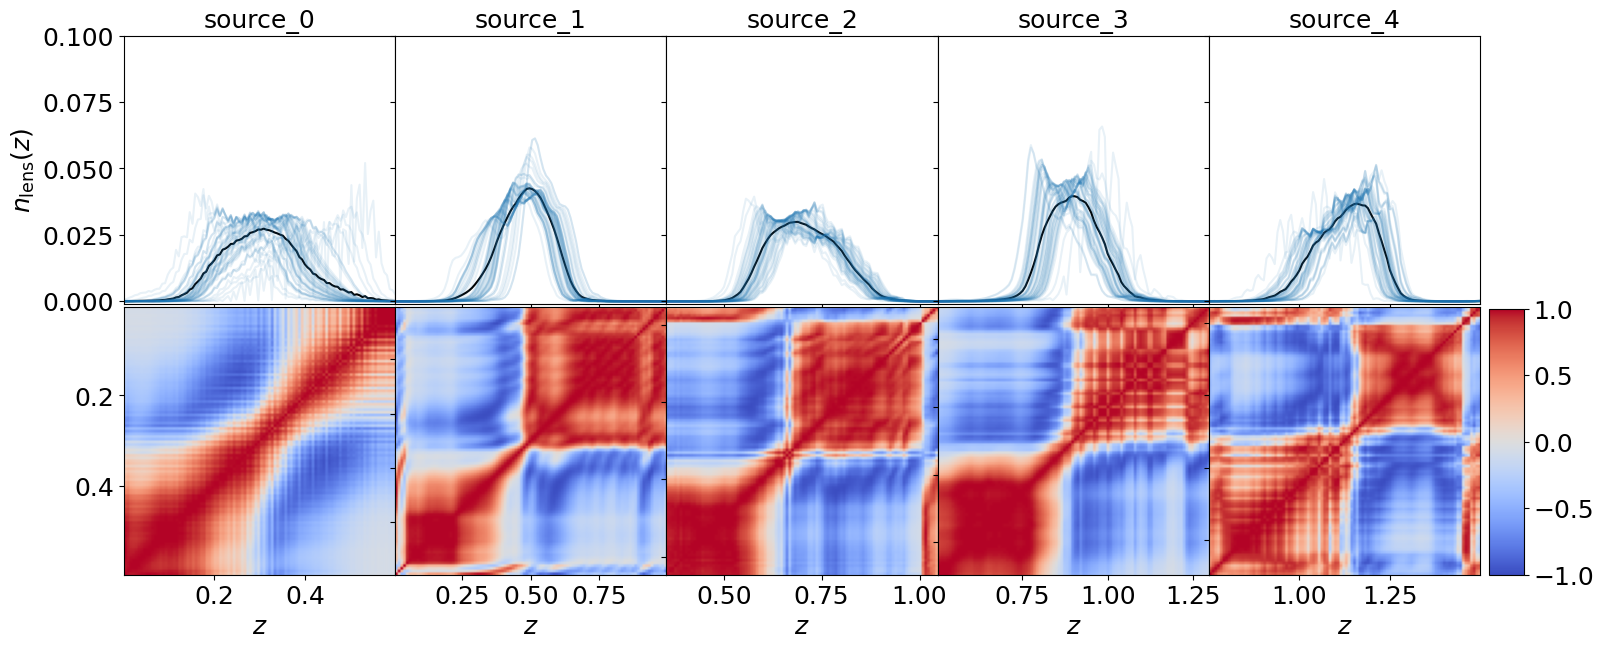

In [5]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(tomos, plot_tracers)

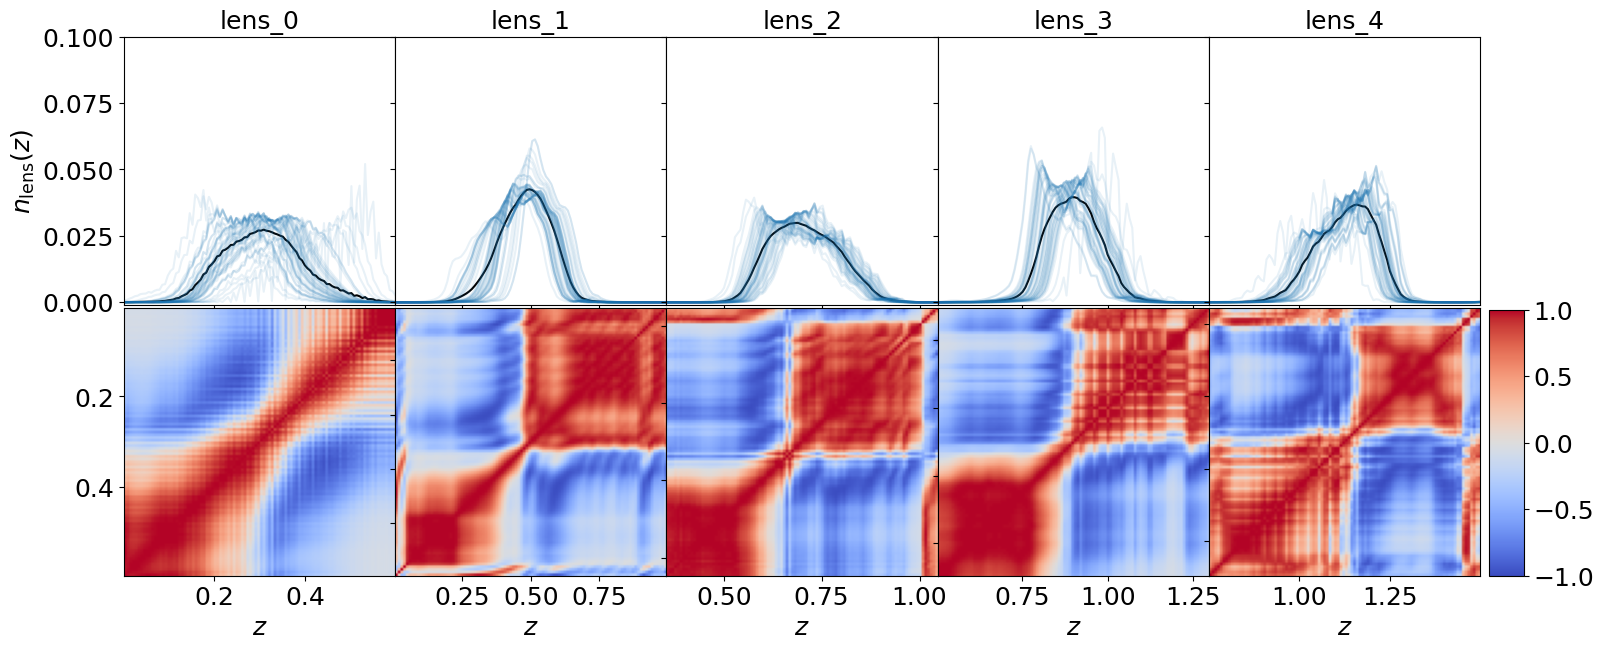

In [6]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(tomos, plot_tracers)

# Interfacing SACC and QP

In [7]:
def make_qp(ens):
    pzs = ens['photo_hists'].T
    zs_edges = ens['zgrid']
    z = 0.5 * (zs_edges[1:] + zs_edges[:-1])
    return z, qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

def update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        ens = enss[key]
        z, q = make_qp(ens)
        #print(q.data['bins'])
        ss.add_tracer('Qpnz', key, q, z=z)
    return ss

ss_qp = update_sacc_qp(s, tomos)

# Computing Uncertainties

Now we are just going to apply the methods of nz_prior described in the basic tutorial for each of the tracers in the sacc file. For the sake of brevity we will only use the qp tracers but the same can be done for the NZTracers.

## Shifts

In [8]:
shifts_priors = nzp.PriorSacc(ss_qp, 
                            model="Shifts",
                            compute_crosscorrs=crosscorrs_method)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


### Prior

In [9]:
labels = [
    r"\Delta z^{\rm source \, 0}",
    r"\Delta z^{\rm source \, 1}",
    r"\Delta z^{\rm source \, 2}",
    r"\Delta z^{\rm source \, 3}",
    r"\Delta z^{\rm source \, 4}",
    r"\Delta z^{\rm lens \, 0}",
    r"\Delta z^{\rm lens \, 1}",
    r"\Delta z^{\rm lens \, 2}",
    r"\Delta z^{\rm lens \, 3}",
    r"\Delta z^{\rm lens \, 4}"]

Removed no burn in
Removed no burn in


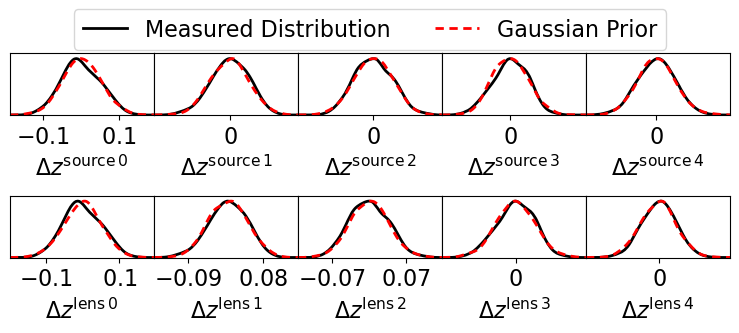

In [10]:
g = shifts_priors.plot_prior(mode="1D", add_prior=True, labels=labels, nx=5, legend_ncol=2, lws=2, ls=['-','--'])
g.export(f"/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/shifts_prior.pdf")

### Likelihood

In [11]:
shifted_nzs = {}
for i in range(2000):
    prior_sample = shifts_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        z = model_obj.z
        nz =  model_obj.nz_mean
        param_names = model_obj.get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        dz = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_and_width_model(z, nz, dz[0], 1)
        if i == 0:
            shifted_nzs[tracer_name] = [z, shifted_nz]
        else:

            shifted_nzs[tracer_name] = [z, np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]


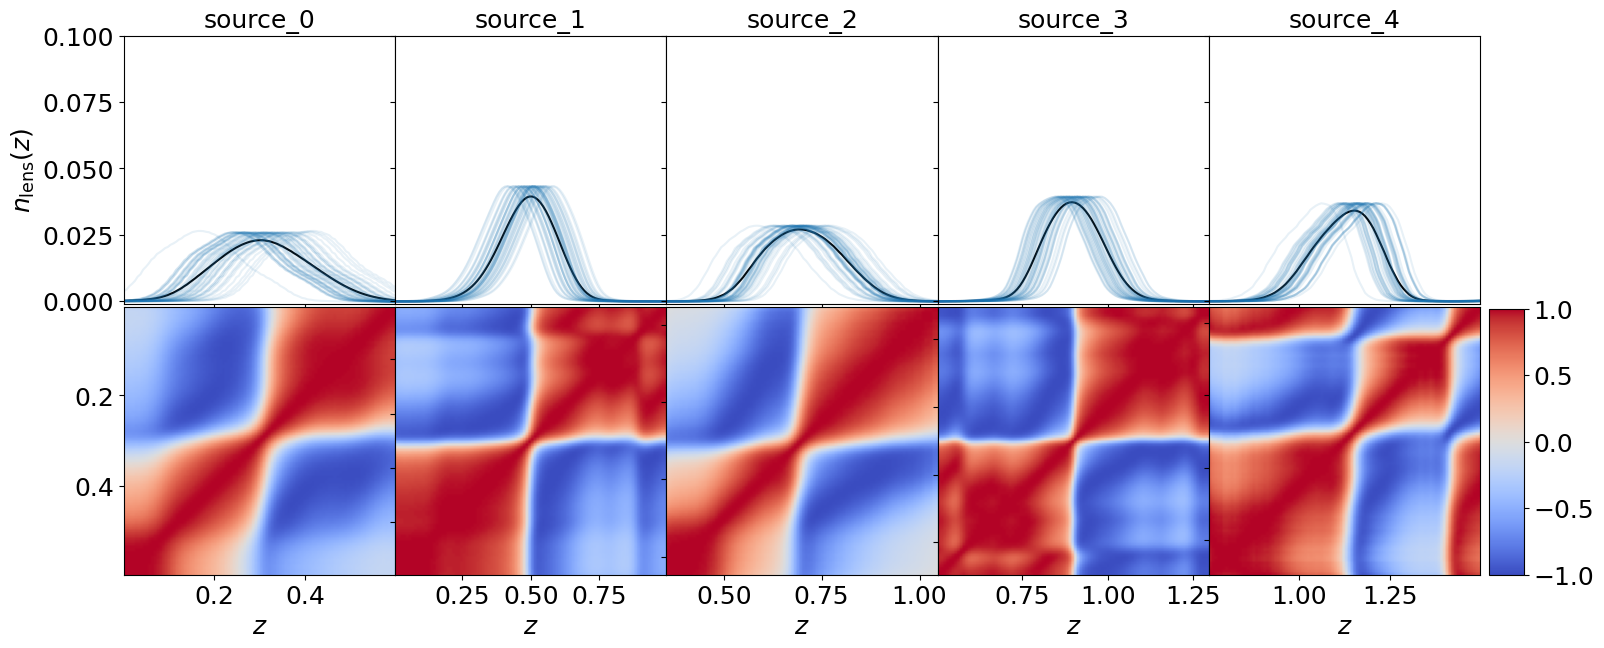

In [12]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(shifted_nzs, plot_tracers)

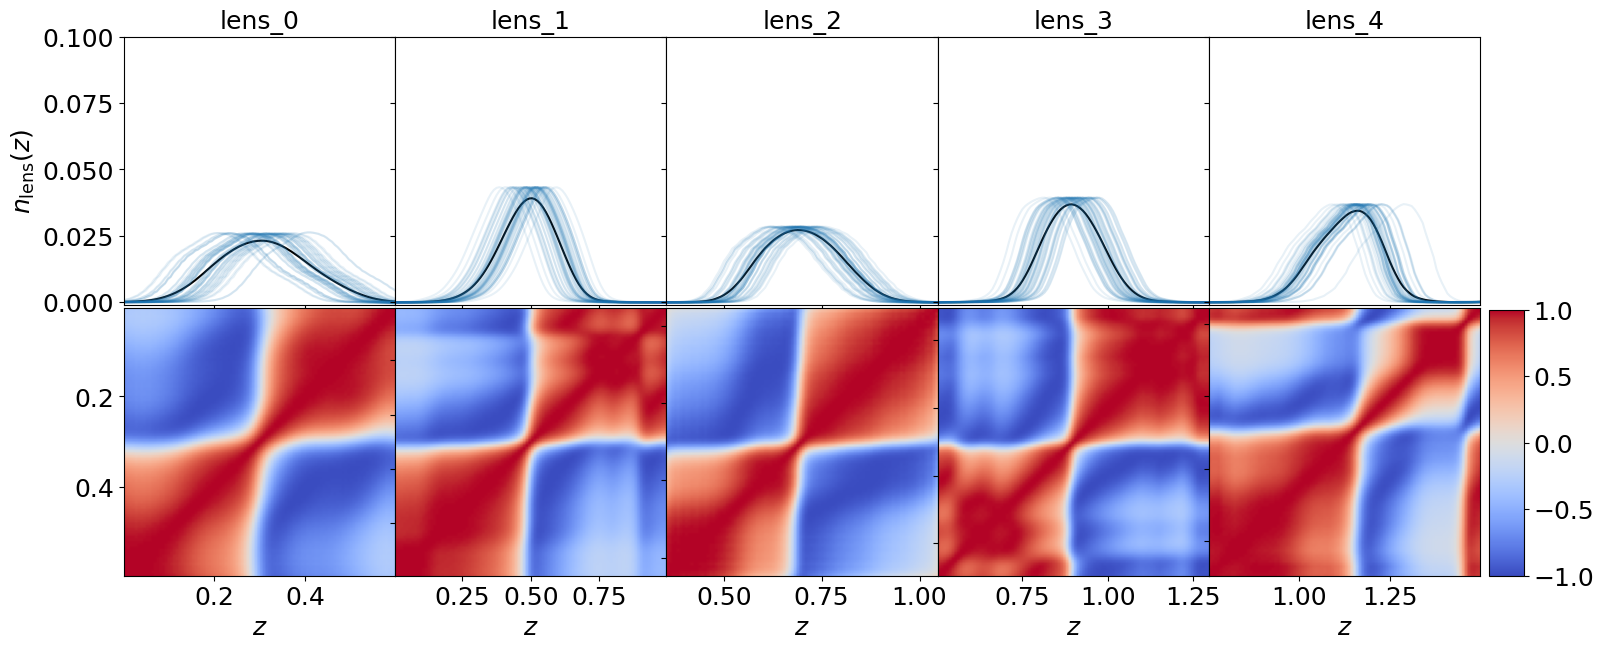

In [13]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(shifted_nzs, plot_tracers)

### Save to Sacc

In [14]:
ss_shifts = shifts_priors.save2sacc("Shifts")

In [15]:
ss_shifts

In [16]:
ss_shifts.save_fits(f"./summary_statistics_fourier_tjpcov_shifts_prior.sacc")

TypeError: Column 'hash/ell_hash' contains unsupported object types or mixed types: {dtype('O')}

In [ ]:
mean = ss_shifts.tracer_uncertainties["Shifts"].mean
W = ss_shifts.tracer_uncertainties["Shifts"].linear_transformation
# Samples of the prior can be generated as:
# theta = mean + W @ np.random.normal(size=W.shape[1])
plt.imshow(W)
plt.colorbar()

## Shifts & widths

In [ ]:
SnWs_priors = nzp.PriorSacc(ss_qp, 
                            model="ShiftsWidths",
                            compute_crosscorrs=crosscorrs_method)

### Prior

In [ ]:
labels = np.array([
    r"\Delta z^{\rm source \, 0}",
    r"w_z^{\rm source \, 0}",
    r"\Delta z^{\rm source \, 1}",
    r"w_z^{\rm source \, 1}",
    r"\Delta z^{\rm source \, 2}",
    r"w_z^{\rm source \, 2}",
    r"\Delta z^{\rm source \, 3}",
    r"w_z^{\rm source \, 3}",
    r"\Delta z^{\rm source \, 4}",
    r"w_z^{\rm source \, 4}",
    r"\Delta z^{\rm lens \, 0}",
    r"w_z^{\rm lens \, 0}",
    r"\Delta z^{\rm lens \, 1}",
    r"w_z^{\rm lens \, 1}",
    r"\Delta z^{\rm lens \, 2}",
    r"w_z^{\rm lens \, 2}",
    r"\Delta z^{\rm lens \, 3}",
    r"w_z^{\rm lens \, 3}",
    r"\Delta z^{\rm lens \, 4}",
    r"w_z^{\rm lens \, 4}"
])

In [ ]:
order = [0, 2, 4, 6, 8, 1, 3, 5, 7, 9,
        10, 12, 14, 16, 18, 11, 13, 15, 17, 19]

In [ ]:
g = SnWs_priors.plot_prior(
    order=order,
    labels=labels, 
    mode="1D", 
    nx=5, 
    legend_ncol=2, 
    lws=2, 
    ls=['-','--'])
g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/SnWs_prior.pdf")

### Likelihood

In [ ]:
SnWs_nzs = {}
for i in range(2000):
    prior_sample = SnWs_priors.sample_prior()
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        z = model_obj.z
        nz = model_obj.nz_mean
        param_names = model_obj.get_params_names()
        nz_names = [tracer_name + "__"  + name for name in param_names]
        s, w = [prior_sample[nz_name] for nz_name in nz_names]
        shifted_nz = nzp.shift_and_width_model(z, nz, s, w)
        if i == 0:
            SnWs_nzs[tracer_name] = [z, shifted_nz]
        else:

            SnWs_nzs[tracer_name] = [z, np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]

In [ ]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

In [ ]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(SnWs_nzs, plot_tracers)

### Save to Sacc

In [ ]:
ss_SnWs = SnWs_priors.save2sacc("ShiftsWidths")

In [ ]:
mean = ss_SnWs.tracer_uncertainties["ShiftsWidths"].mean
W = ss_SnWs.tracer_uncertainties["ShiftsWidths"].linear_transformation
# Samples of the prior can be generated as:
# theta = mean + W @ np.random.normal(size=W.shape[1])
plt.imshow(W)
plt.colorbar()

## GP

In [ ]:
gp_priors = nzp.PriorSacc(ss_qp,
                            model="GP",
                            compute_crosscorrs=crosscorrs_method,
                            n=5)

### Prior

In [ ]:
labels = [
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 0}" for q in gp_priors.model_objs['source_0'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 1}" for q in gp_priors.model_objs['source_1'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 2}" for q in gp_priors.model_objs['source_2'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 3}" for q in gp_priors.model_objs['source_3'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 4}" for q in gp_priors.model_objs['source_4'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 0}" for q in gp_priors.model_objs['lens_0'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 1}" for q in gp_priors.model_objs['lens_1'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 2}" for q in gp_priors.model_objs['lens_2'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 3}" for q in gp_priors.model_objs['lens_3'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 4}" for q in gp_priors.model_objs['lens_4'].q],
]
labels = np.array(labels).flatten()

In [ ]:
g = gp_priors.plot_prior(mode="1D", add_prior=True, labels=labels, nx=5, legend_ncol=2, lws=2, ls=['-','--'])
g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/gp_priors.pdf")

### Likelihood

In [ ]:
gp_nzs = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = gp_priors.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    z = model_obj.z
    _, _, chol = model_obj.get_prior()
    W = model_obj.prior_transform
    _nzs = np.array([nzp.linear_model(nz_mean, W, np.random.randn(5)) for i in range(2000)])
    gp_nzs[tracer_name] = [z, _nzs]

In [ ]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(gp_nzs, plot_tracers)

In [ ]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(gp_nzs, plot_tracers)

### Save to Sacc

In [ ]:
ss_gp = gp_priors.save2sacc("GP")

In [ ]:
mean = ss_gp.tracer_uncertainties["GP"].mean
W = ss_gp.tracer_uncertainties["GP"].linear_transformation
# Samples of the prior can be generated as:
# theta = mean + W @ np.random.normal(size=W.shape[1])
plt.imshow(W, aspect='auto')
plt.colorbar()

# PCA

In [ ]:
PCA_priors = nzp.PriorSacc(ss_qp,
                            model="PCA",
                            compute_crosscorrs=crosscorrs_method,
                            n=5)

### Prior

In [ ]:
labels = [
    r"\alpha_{1}^{\rm source \, 0}",
    r"\alpha_{2}^{\rm source \, 0}",
    r"\alpha_{3}^{\rm source \, 0}",
    r"\alpha_{4}^{\rm source \, 0}",
    r"\alpha_{5}^{\rm source \, 0}",
    r"\alpha_{1}^{\rm source \, 1}",
    r"\alpha_{2}^{\rm source \, 1}",
    r"\alpha_{3}^{\rm source \, 1}",
    r"\alpha_{4}^{\rm source \, 1}",
    r"\alpha_{5}^{\rm source \, 1}",
    r"\alpha_{1}^{\rm source \, 2}",
    r"\alpha_{2}^{\rm source \, 2}",
    r"\alpha_{3}^{\rm source \, 2}",
    r"\alpha_{4}^{\rm source \, 2}",
    r"\alpha_{5}^{\rm source \, 2}",
    r"\alpha_{1}^{\rm source \, 3}",
    r"\alpha_{2}^{\rm source \, 3}",
    r"\alpha_{3}^{\rm source \, 3}",
    r"\alpha_{4}^{\rm source \, 3}",
    r"\alpha_{5}^{\rm source \, 3}",
    r"\alpha_{1}^{\rm source \, 4}",
    r"\alpha_{2}^{\rm source \, 4}",
    r"\alpha_{3}^{\rm source \, 4}",
    r"\alpha_{4}^{\rm source \, 4}",
    r"\alpha_{5}^{\rm source \, 4}",
    r"\alpha_{1}^{\rm lens \, 0}",
    r"\alpha_{2}^{\rm lens \, 0}",
    r"\alpha_{3}^{\rm lens \, 0}",
    r"\alpha_{4}^{\rm lens \, 0}",
    r"\alpha_{5}^{\rm lens \, 0}",
    r"\alpha_{1}^{\rm lens \, 1}",
    r"\alpha_{2}^{\rm lens \, 1}",
    r"\alpha_{3}^{\rm lens \, 1}",
    r"\alpha_{4}^{\rm lens \, 1}",
    r"\alpha_{5}^{\rm lens \, 1}",
    r"\alpha_{1}^{\rm lens \, 2}",
    r"\alpha_{2}^{\rm lens \, 2}",
    r"\alpha_{3}^{\rm lens \, 2}",
    r"\alpha_{4}^{\rm lens \, 2}",
    r"\alpha_{5}^{\rm lens \, 2}",
    r"\alpha_{1}^{\rm lens \, 3}",
    r"\alpha_{2}^{\rm lens \, 3}",
    r"\alpha_{3}^{\rm lens \, 3}",
    r"\alpha_{4}^{\rm lens \, 3}",
    r"\alpha_{5}^{\rm lens \, 3}",
    r"\alpha_{1}^{\rm lens \, 4}",
    r"\alpha_{2}^{\rm lens \, 4}",
    r"\alpha_{3}^{\rm lens \, 4}",
    r"\alpha_{4}^{\rm lens \, 4}",
    r"\alpha_{5}^{\rm lens \, 4}",
]

In [ ]:
g = PCA_priors.plot_prior(mode="1D", add_prior=True, nx=5, labels=labels, legend_ncol=2, lws=2, ls=['-','--'])
g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/pca_priors.pdf")

### Likelihood

In [ ]:
pca_nzs = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = PCA_priors.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    z = model_obj.z
    W = model_obj.prior_transform
    _nzs = np.array([nzp.linear_model(nz_mean, W, np.random.randn(5)) for i in range(2000)])
    pca_nzs[tracer_name] = [z, _nzs]

In [ ]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(pca_nzs, plot_tracers)

In [ ]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(pca_nzs, plot_tracers)

### Save to Sacc

In [ ]:
ss_PCA = PCA_priors.save2sacc("PCA")

In [ ]:
mean = ss_PCA.tracer_uncertainties["PCA"].mean
W = ss_PCA.tracer_uncertainties["PCA"].linear_transformation
# Samples of the prior can be generated as:
# theta = mean + W @ np.random.normal(size=W.shape[1])
plt.imshow(W, aspect='auto')
plt.colorbar()

# Comparison

In [ ]:
def make_nzs_comp_plot(methods, tracer):
    n_tracers = len(methods)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(methods):
        method = methods[key]
        tomo = method[tracer]
        if len(tomo) == 2:
            nzs = tomo[1][:50].T
            zs = tomo[0]
        else:
            nzs = tomo['photo_hists'].T[:50].T
            zs = tomo['znodes']
        nz_mean = np.mean(nzs, axis=1)
        norms = np.sum(nzs, axis=0)
        axis[0,i].plot(zs, nz_mean/np.sum(nz_mean), '-', color="k")
        axis[0,i].plot(zs, nzs/norms, '-', color="C0", alpha=0.1)
        cov = np.cov(nzs)
        err = np.sqrt(np.diag(cov))
        corr = cov/np.outer(err, err)
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_ylim([-0.001, 0.1])
        axis[0,i].set_title(key, y=0.9)
        if i == 0:
            axis[0,i].set_ylabel(r'$n_{\rm source \, 0}(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(corr, aspect='auto',
                            origin='lower', cmap='coolwarm',
                             vmin=-1, vmax=1,
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()
    return figure

In [ ]:
g = make_nzs_comp_plot({'Data': tomos, 'Shifts':shifted_nzs, 'Shifts & Widths':SnWs_nzs, 'PCA':pca_nzs, 'GP':gp_nzs}, 'source_0')
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/source_0_validation.pdf", bbox_inches='tight')